# Music STEMS Final Project
## Kai Kaneshina and Gabriel Quiroz

In [1]:
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.signal as ss
import scipy.io as sio
import glob
import subprocess
import os.path
import pickle

## Database Constructor

In [2]:
def constructDatabase(indir):
    """
    Construct a database of fingerprints for all mp3 files in the specified directory.
    
    Arguments:
    indir -- directory containing mp3 files
    
    Returns:
    d -- database of artist names, where the key is the artist name
        and the value is the audio array extracted with librosa.
    """
    d = {}

    ### START CODE BLOCK ###
    path = indir + '/*.m4a'
    for filename in glob.iglob(path, recursive=True):  
        audio, sr = lb.core.load(filename, 22050)
        filename = filename.lstrip(indir + '/') #removes the directory from the filename
        name = filename.split(' ')[0] #keeps only the name of the artist
        d[name] = audio
            
    ### END CODE BLOCK ###
    
    return d

In [3]:
db_Scales = constructDatabase('scales') # note that this may take a minute or so to run

In [4]:
with open('db_Scales.pkl','wb') as scales:
    pickle.dump(db_Scales, scales)

In [5]:
with open('db_Scales.pkl','rb') as scales:
    db_Scales = pickle.load(scales)

In [6]:
db_JingleBells = constructDatabase('song') # note that this may take a minute or so to run

In [7]:
with open('db_JingleBells.pkl','wb') as JingleBells:
    pickle.dump(db_JingleBells, JingleBells)

In [8]:
with open('db_JingleBells.pkl','rb') as JingleBells:
    db_JingleBells = pickle.load(JingleBells)

## Functions for Visualization 

In [9]:
def visualizeTemplate(W):
    '''This function allows us the visualize the template matrix (W)'''
    fs = 22050
    winsz = 2048
    
    maxFreq = W.shape[0]*fs/winsz
    maxMidi = W.shape[1]
    
    plt.figure(figsize=(16,5))
    plt.imshow(W, cmap='jet', origin = 'lower', aspect='auto', extent=(0, maxMidi, 0, maxFreq))
    plt.xlabel('Note')
    plt.ylabel('Frequency [Hz]')
    plt.title('Template Matrix Visualization')
    plt.colorbar()
    plt.show()

In [10]:
def visualizeActivations(H):
    '''This function allows us the visualize the activations matrix (H)'''
    fs = 22050
    winsz = 2048
    
    maxNote = H.shape[0]
    maxFrame = H.shape[1]
    
    plt.figure(figsize=(16,5))
    plt.imshow(H, cmap='jet', origin = 'lower', aspect='auto', extent=(0, maxFrame, 0, maxNote))
    plt.xlabel('Frames')
    plt.ylabel('Note')
    plt.title('Activation Matrix Visualization')
    plt.colorbar()
    plt.show()

In [11]:
def visualizeSTFT(STFT):
    '''This function allows us to visualize the log spectrogram of the STFT'''
    fs = 22050
    winsz = 2048
    
    maxFreq = STFT.shape[0]*fs/winsz
    maxFrame = STFT.shape[1]
    
    plt.figure(figsize=(16,5))
    plt.imshow(np.log(STFT), cmap='jet', vmin=-12, origin = 'lower', aspect='auto', extent=(0, maxFrame, 0, maxFreq))
    plt.xlabel('Frame')
    plt.ylabel('Frequency [Hz]')
    plt.title('STFT Visualization')
    plt.colorbar()
    plt.show()

## NMF

In [12]:
def calcSTFT(audio, sr = 22050, winsz = 2048, hop = 512):
    '''Calculate the STFT of the audio'''
    f, t, Zxx = ss.stft(audio, sr, nperseg=winsz, noverlap=winsz-hop)
    return Zxx

In [13]:
def NMF(W, H, V):
    '''The NMF function runs the algorithm until the NMF algorithm causes a change of less than 1e-6 '''
    
    count = 0
    while(True):
        prevEstimate = np.linalg.norm(V - np.matmul(W,H))
        
        H = (H*np.matmul(W.T, V))/(np.matmul(np.matmul(W.T, W), H))
        W = (W*np.matmul(V, H.T))/(np.matmul(np.matmul(W, H), H.T))
        
        count += 1
        newEstimate = np.linalg.norm(V - np.matmul(W,H))
        
        # Take the difference of the previous and newly computed values 
        # If the number is small, then that means there has been little to no change within the NMF algorithm
        # and thus we can stop running the function
        if np.abs(newEstimate - prevEstimate) <= 1e-6:
            break
    return W, H, count 

## Initializing templates

In [14]:
def initTemplates(STFT, midiArray, deltaF=30, sr=22050, winSize=2048):
    '''Creates the initial template for the W matrix'''
    # Convert the midi array values into a frequency array
    freqArray = 440 * pow(2, (midiArray-69)/12)
    
    # Convert the frequency array into an array of k values. Also convert deltaF into a k value as well.
    kArray = np.round(freqArray*winSize/sr).astype(int)
    deltaK = np.round(deltaF*winSize/sr).astype(int)
    
    # Create W with the same amount of rows as the STFT, and the amount of columns equal to number of notes
    W = np.zeros([STFT.shape[0], len(kArray)])
    
    # Loop through the rows in each column
    for i in range(W.shape[1]):
        for j in range(W.shape[0]):
            
            # If our k value is a multiple of the row, we have hit the note, and/or its harmonic
            if (j%kArray[i]==0):
                
                # Set the W array row equal to the max value
                W[j,i] = np.random.rand()
                
                # Cases for harmonics are below, first init an array for the k values required to satisfy values
                # around harmonic frequencies
                deltaKRange = np.arange(1, (deltaK+1)*j/kArray[i])
                
                # We add the harmonic value to a range of k values based off of the deltaF entered
                harmonicsPositive = j + deltaKRange
                
                # We then remove any k values that are greater than or equal to the amount of rows  
                harmonicsPositive = np.delete(harmonicsPositive, np.where(harmonicsPositive>=W.shape[0])).astype(int)
                
                # We subtract a range of k values based off of the deltaF entered from the harmonic value
                harmonicsNegative = j - deltaKRange
                
                # We then remove any k values that are less than 0 to avoid the out of bounds error  
                harmonicsNegative = np.delete(harmonicsNegative, np.where(harmonicsNegative<0)).astype(int)
                
                # If an array is non-empty, we set the harmonic value + the deltaK values to be a random number

                if harmonicsPositive.size > 0:
                    # Create as many random numbers as indices selected
                    W[harmonicsPositive, i] = np.random.rand(harmonicsPositive.size)
                    
                if harmonicsNegative.size > 0:
                    # Create as many random numbers as indices selected
                    W[harmonicsNegative, i] = np.random.rand(harmonicsNegative.size)
            
    return W        

## Random Activation Initialization

In [15]:
def naiveMatrixInit(STFT):
    '''This function randomly fills in the W and H matrices with floats'''
    numRows, numCols = STFT.shape
    numNotes = 8
    H = np.random.rand(numNotes, numCols)
    return H

## Score Metric

In [16]:
def accuracyScore(queryStftMag, queryActivation, template):
    
    '''
    This function calculates and returns the score for how accurately a scale matches up with the query.
    '''
    
    vEstimate = np.matmul(template, queryActivation)
    absDiff = np.abs(queryStftMag - vEstimate)
    score = np.sum(absDiff)
    
    return score

## Initiate template and activation matrices for the scales

In [17]:
def getAudioTemplatesNMF(db_Scales, midiNotes):

    '''
    This function initializes a random H matrix and a W matrix for the audio based on the scale of the midi
    notes, as well as the STFT, which are used for the NMF function. The function returns a database with the 
    artist's name as the key and W matrix as the value. 
    '''
    
    # Initialize W 
    dbW = {}
    
    # Loop through dictionary's items
    for artist, audio in db_Scales.items():

        # Calculations required for NMF 
        STFT = calcSTFT(audio)
        magSTFT = np.abs(STFT)
        initW = initTemplates(magSTFT, midiNotes)
        
        # Initialize Random Activation Matrix
        randH = naiveMatrixInit(STFT)
        
        # Run the NMF algorithm
        W, H, count = NMF(initW + 1e-9, randH + 1e-9, magSTFT)

        # Save the H, W, and STFT magnitude values to their respective dictionaries.
        dbW[artist] = W

    return dbW

In [18]:
def calculateSinger(db_Queries, db_Templates):
    
    '''
    This function iterates through all the queries, calculates the stft of the query, and then iterates through all
    the artist templates. It then calculates the optimal activation matrix as well as the corresponding score. 
    The lowest score calculated equates to the best artist template that matches the query, and we store the query 
    artist name with the template name and its score into a dictionary. The function then returns the dictionary.
    '''
    
    # Initialize pairing dictionary
    singerPairings = {}
    
    # Loop through the query dictionary's items
    for artistQuery, audio in db_Queries.items():
        
        print('Query Artist Name: ' , artistQuery)
        
        # Calculate STFT for the query
        STFT = calcSTFT(audio)
        magSTFT = np.abs(STFT)
        bestArtist = ''
        lowestScore = np.inf
        
        # Iterate through all the templates, 
        for artistTemplate, template in db_Templates.items():
            
            artistActivation = np.matmul(np.linalg.inv(np.matmul(template.T, template)), 
                                     np.matmul(template.T, magSTFT))
            
            score = accuracyScore(magSTFT, artistActivation, template)
            print('Template Name and Score: ', artistTemplate, ', ', score)
            
            if score < lowestScore:
                bestArtist = artistTemplate
                lowestScore = score
                
        print('Best Template Match: ', bestArtist)        
        singerPairings[artistQuery] = (bestArtist, lowestScore)
            
    return singerPairings

In [19]:
midiNotes = np.array([60, 62, 64, 65, 67, 69, 71, 72]) # This list contains the midi values for notes C4 to C5 aka 60 to 72, skipping sharps

In [20]:
db_Templates = getAudioTemplatesNMF(db_Scales, midiNotes)

In [21]:
singerPairings = calculateSinger(db_JingleBells, db_Templates)

Query Artist Name:  Cynthia
Template Name and Score:  Sabrina ,  98.56963284595095
Template Name and Score:  Cynthia ,  92.20217945949825
Template Name and Score:  Willis ,  109.39051785443567
Template Name and Score:  Kaitlyn ,  101.95347009569258
Template Name and Score:  Gary ,  102.88216292750279
Template Name and Score:  Lilly ,  92.6443521874755
Template Name and Score:  Maddie ,  95.07435738875112
Template Name and Score:  Gabe ,  110.73070425552378
Template Name and Score:  Hannah ,  101.48232920879886
Template Name and Score:  Kailee ,  88.07266847777223
Best Template Match:  Kailee
Query Artist Name:  Kailee
Template Name and Score:  Sabrina ,  236.60179532369517
Template Name and Score:  Cynthia ,  215.07139858114292
Template Name and Score:  Willis ,  265.30386462568265
Template Name and Score:  Kaitlyn ,  228.78001778738525
Template Name and Score:  Gary ,  253.93491725482707
Template Name and Score:  Lilly ,  224.2506476985212
Template Name and Score:  Maddie ,  206.26788

In [22]:
def accuracyTest(singerPairings):
    
    '''
    This function is used to test the accuracy of the system.
    '''
    
    # Initialize variables
    amountCorrect = 0
    totalSongs = len(singerPairings)
    
    # Loop through the singerPairings database 
    for querySinger, resultsSingerAndScore in singerPairings.items():
        
        if querySinger == resultsSingerAndScore[0]:
            amountCorrect += 1
    
    return amountCorrect/totalSongs

In [23]:
accuracy = accuracyTest(singerPairings)

In [24]:
accuracy

0.3

In [25]:
def accuracyTestMultiple(db_JingleBells, db_Scales, midiNotes, numTests):
    '''
    This function is used to run multiple tests on the databases of scales and songs. It outputs the average 
    accuracy after numTests are run.
    '''
    
    totalAccuracy = 0
    totalIterations = numTests
    
    while(numTests>=1):
        # Get the templates based off the scales
        db_Templates = getAudioTemplatesNMF(db_Scales, midiNotes)
        
        # Create the singer pairings dictionary 
        singerPairings = calculateSinger(db_JingleBells, db_Templates)
        
        # Get the overall accuracy
        totalAccuracy += accuracyTest(singerPairings)
        
        numTests -= 1
        
    return totalAccuracy / totalIterations  

In [26]:
# accuracy10Tests = accuracyTestMultiple(db_JingleBells, db_Scales, midiNotes, 10)

In [27]:
# print(accuracy10Tests)

# Archive

## Midi Notes and Timing

In [28]:
def noteToIdx(note):
    '''
    This function will be used to transcribe the given note into an index value (0-11). 
    '''
    
    if note == 'C':
        return 0
    elif note=='C#': 
        return 1
    elif note=='D':
        return 2
    elif note=='D#':
        return 3
    elif note=='E':
        return 4
    elif note=='F':
        return 5
    elif note=='F#':
        return 6
    elif note=='G':
        return 7
    elif note=='G#':
        return 8
    elif note=='A':
        return 9
    elif note=='A#':
        return 10
    else:
        # Case for when the note is B
        return 11

In [29]:
def notesToIdx(noteArray):
    
    '''
    This function will be used to transcribe the given notes into an index value (0-11) array. 
    '''
    
    noteIdxArray = []
    
    for i in range(len(noteArray)):
        
        noteIdxArray.append(noteToIdx(noteArray[i]))
    
    return np.array(noteIdxArray)

In [30]:
def createNoteEvents(notes,noteStartTimesArray):
    
    '''
    This function is used to convert the notes into indices and then 
    combine the note indices with their corresponding start times.
    '''
    
    noteEvents = []
    
    noteIdxArray = notesToIdx(notes)

    for i in range(len(noteIdxArray)):
        
        noteEvents.append((noteIdxArray[i], noteStartTimesArray[i]))
    
    return noteEvents

In [31]:
# Notes and timing for Jingle Bells were transcribing using the chorus found here: 
# https://www.bethsnotesplus.com/2014/07/jingle-bells.html

notes = np.array(['E', 'E', 'E', 'E', 'E', 'E', 'E', 'G', 'C', 'D', 'E', 'F', 'F', 'F', 'F', 'F', 'E', 'E',   
                  'E', 'E', 'E', 'D', 'D', 'E', 'D'])
    
    #, 'G'
    
notesB = np.array(['B', 'B', 'B', 'B', 'B', 'B', 'B', 'D', 'G', 'A', 'B', 'C', 'C', 'C', 'C', 'C', 'B', 
                   'B', 'B', 'B', 'B', 'A', 'A', 'B', 'A', 'D','B', 'B', 'B', 'B', 'B', 'B', 'B', 'D', 
                   'G', 'A', 'B', 'C', 'C', 'C', 'C', 'C', 'B', 'B', 'B', 'B', 'D', 'D', 'C', 'A', 'G'])

noteTiming = np.array([0,1,2,4,5,6,8,9,10,11.5,12,17,18,19.5,20,21,22,23,23.5,24,25,26,27,28,30,32,33,34,36,
                       37,38,40,41,42,43.5,44,48,49,50,51.5,52,53,54,55,55.5,56,57,58,59,60,64])

noteStartTimes = np.array([0, 0.24,  0.48,  0.96,  1.2 ,  1.44,  1.92,  2.16,  2.4 ,  2.76,
        2.88,  4.08,  4.32,  4.68,  4.8 ,  5.04,  5.28,  5.52,  5.64,
        5.76,  6.  ,  6.24,  6.48,  6.72,  7.2 ,  7.68,  7.92,  8.16,
        8.64,  8.88,  9.12,  9.6 ,  9.84, 10.08, 10.44, 10.56, 11.52,
       11.76, 12.  , 12.36, 12.48, 12.72, 12.96, 13.2 , 13.32, 13.44,
       13.68, 13.92, 14.16, 14.4 , 15.36])

In [32]:
noteEvents = createNoteEvents(notes, noteStartTimes[:len(notes)])

## Initialize Activations

In [33]:
def initActivations(Zxx, midiNotes, noteEvents, fs=22050, hopsize=512, deltaT=.5):
    '''This function allows us to initialize the H matrix by utilizing the STFT and the noteEvents.'''
    
    numNotes = len(midiNotes)
    numFrames = Zxx.shape[1]
    H = np.zeros([numNotes, numFrames])
    maxNoteLengthInFrames = int(1*fs/hopsize) #this value is for the 1 second that each note plays for
    deltaFrames = int(deltaT*fs/hopsize) #converts the deltaT (onset value) into frames
    
    # Create a range of values that span from the -onset value to the totalDuration + the onset value
    noteLengthInFrames = np.arange(-deltaFrames, maxNoteLengthInFrames + deltaFrames + 1) 
    for i in range(len(noteEvents)):
        note = noteEvents[i][0]
        actTime = noteEvents[i][1] #time when the note is activated 
        actFrame = int(actTime*fs/hopsize) #convert the time into frames
        
        # Creates an array of frame values that need to be set to random, non-zero numbers
        noteTimeActive = actFrame + noteLengthInFrames 
        
        # Remove frames that are less than zero and greater than shape of activation matrix
        noteTimeActive = np.delete(noteTimeActive, np.where(noteTimeActive < 0)).astype(int)
        noteTimeActive = np.delete(noteTimeActive, np.where(noteTimeActive >= H.shape[1])).astype(int)
        
        # Create as many random numbers as indices selected
        H[note, noteTimeActive] = np.random.rand(noteTimeActive.size)
        
    return H

## Experimentation

In [34]:
def NMFFixedW(W, V):
    '''The NMF function with a fixed W matrix runs the algorithm until it causes a change of less than 1e-6 '''
    
    H = naiveMatrixInit(V)
    count = 0
    while(True):
        prevEstimate = np.linalg.norm(V - np.matmul(W,H))
        
        H = (H*np.matmul(W.T, V))/(np.matmul(np.matmul(W.T, W), H))
        
        count += 1
        newEstimate = np.linalg.norm(V - np.matmul(W,H))
        
        # Take the difference of the previous and newly computed values 
        # If the number is small, then that means there has been little to no change within the NMF algorithm
        # and thus we can stop running the function
        if np.abs(newEstimate - prevEstimate) <= 1e-6:
            break
    return H

In [35]:
def calculateSingerFixedW(db_Queries, db_Templates):
    
    '''
    This function iterates through all the queries, calculates the stft of the query, and then iterates through all
    the artist templates. It then calculates the optimal activation matrix as well as the corresponding score. 
    The lowest score calculated equates to the best artist template that matches the query, and we store the query 
    artist name with the template name and its score into a dictionary. The function then returns the dictionary.
    '''
    
    # Initialize pairing dictionary
    singerPairings = {}
    
    # Loop through the query dictionary's items
    for artistQuery, audio in db_Queries.items():
        
        print('Query Artist Name: ' , artistQuery)
        
        # Calculate STFT for the query
        STFT = calcSTFT(audio)
        magSTFT = np.abs(STFT)
        bestArtist = ''
        lowestScore = np.inf
        
        # Iterate through all the templates, 
        for artistTemplate, template in db_Templates.items():
            
            artistActivation = NMFFixedW(template, magSTFT)
            
            curScore = accuracyScore(magSTFT, artistActivation, template)
            print('Template Name and Score: ', artistTemplate, ', ', curScore)
            
            if curScore < lowestScore:
                bestArtist = artistTemplate
                lowestScore = curScore
                
        print('Best Template Match: ', bestArtist)        
        singerPairings[artistQuery] = (bestArtist, lowestScore)
            
    return singerPairings

In [36]:
singerPairingsFixedW = calculateSingerFixedW(db_JingleBells, db_Templates)

Query Artist Name:  Cynthia
Template Name and Score:  Sabrina ,  98.30322077902923
Template Name and Score:  Cynthia ,  91.8285877087168
Template Name and Score:  Willis ,  105.51641104759891
Template Name and Score:  Kaitlyn ,  101.30842327476978
Template Name and Score:  Gary ,  101.41000428581194
Template Name and Score:  Lilly ,  91.47390427003198
Template Name and Score:  Maddie ,  94.07964402315406
Template Name and Score:  Gabe ,  108.21375641803105
Template Name and Score:  Hannah ,  100.7278541222948
Template Name and Score:  Kailee ,  87.86698688120981
Best Template Match:  Kailee
Query Artist Name:  Kailee
Template Name and Score:  Sabrina ,  235.7990834073736
Template Name and Score:  Cynthia ,  214.61062963680996
Template Name and Score:  Willis ,  250.12613283949844
Template Name and Score:  Kaitlyn ,  228.56034543692445
Template Name and Score:  Gary ,  248.3106512139076
Template Name and Score:  Lilly ,  218.0973429679476
Template Name and Score:  Maddie ,  203.82164950

In [37]:
accuracyScoreFixedW = accuracyTest(singerPairings)

In [38]:
accuracyScoreFixedW

0.3

## Visualization testing

Sabrina


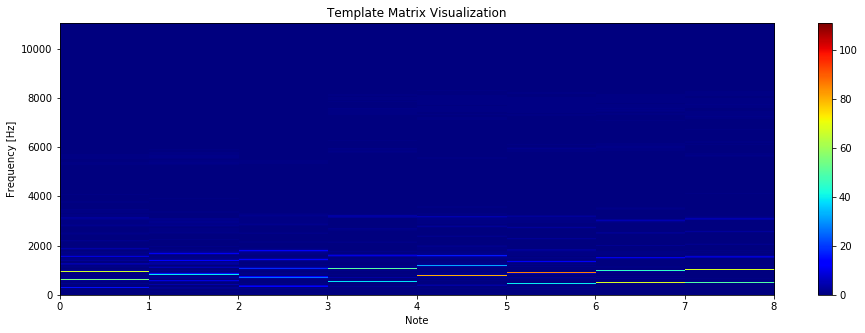

Cynthia


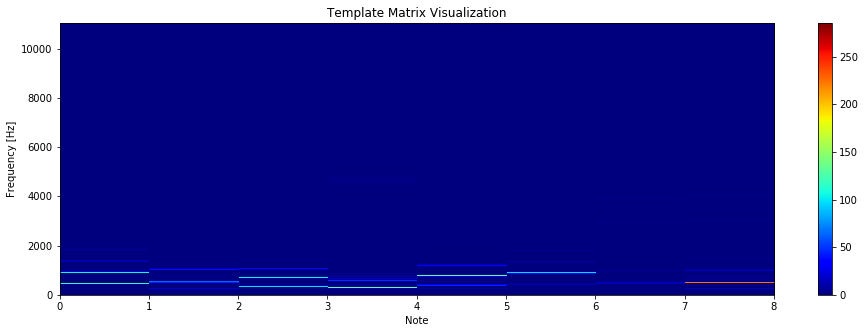

Willis


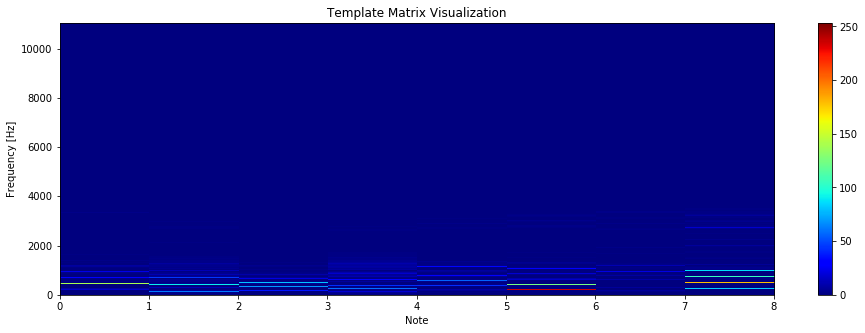

Kaitlyn


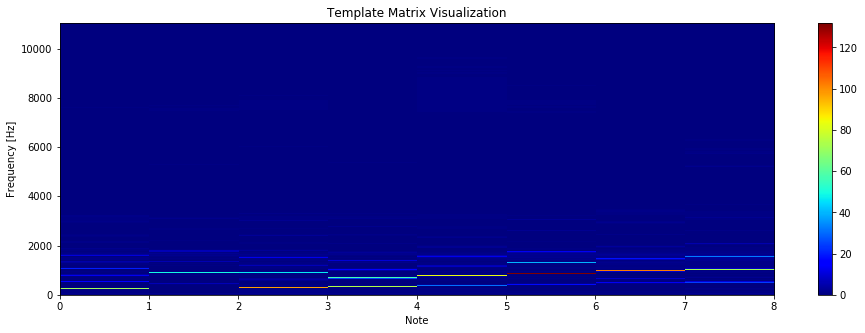

Gary


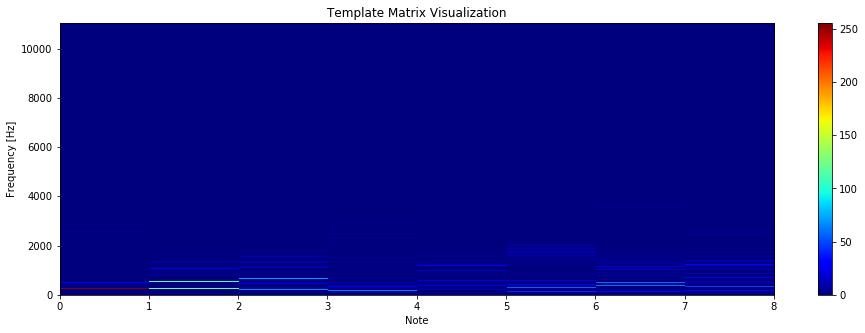

Lilly


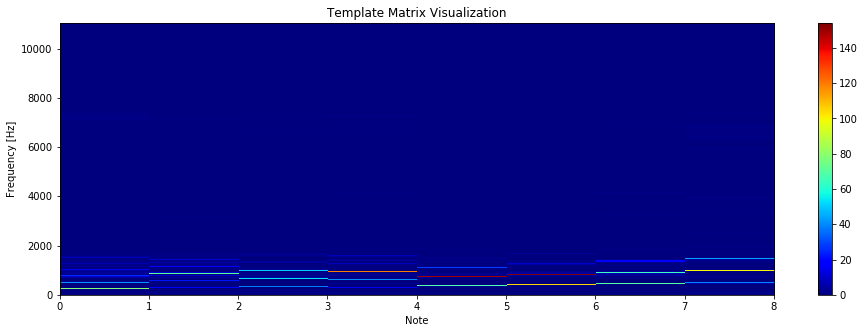

Maddie


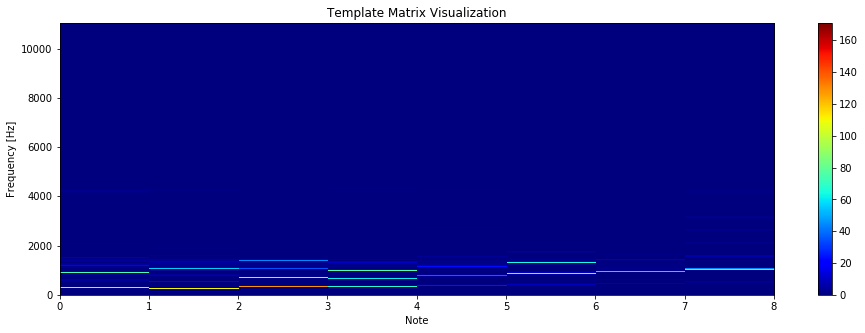

Gabe


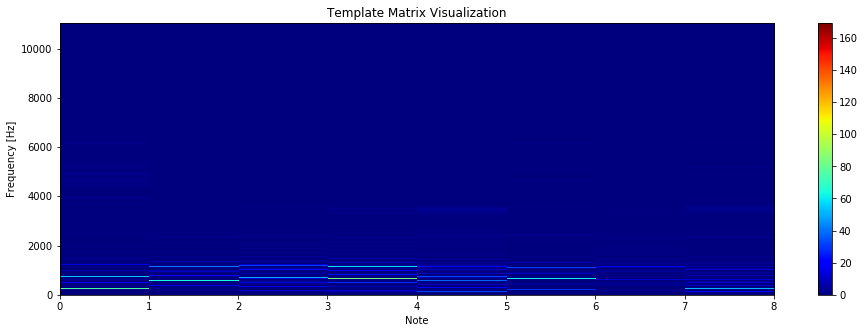

Hannah


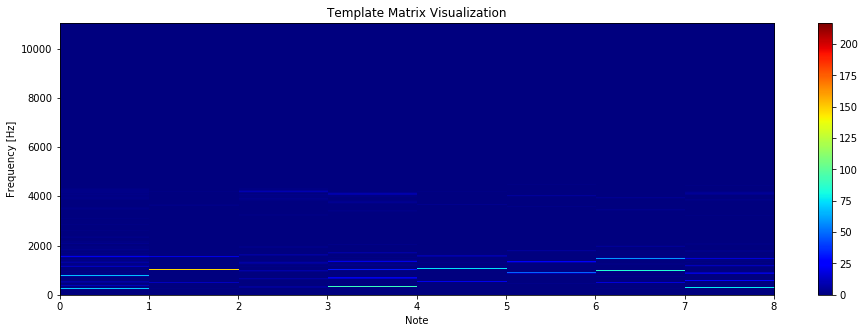

Kailee


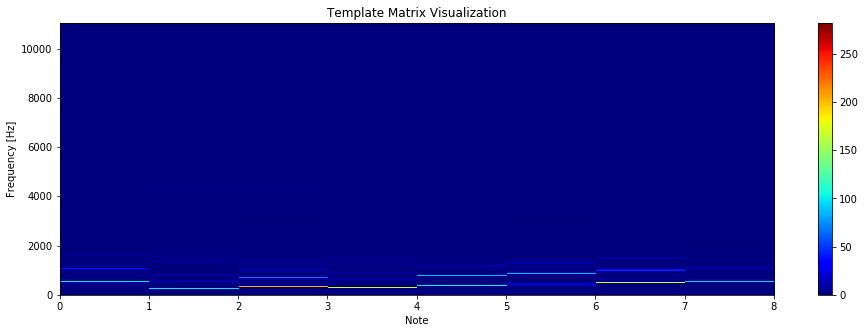

In [39]:
for name, audio in db_Templates.items():
    print(name)
#     visualizeSTFT(np.abs(calcSTFT(audio)))
    visualizeTemplate(db_Templates[name])


In [40]:
for name, audio in db_Scales.items():
    print(name)
#     visualizeSTFT(np.abs(calcSTFT(audio)))
#     visualizeTemplate(db_Templates[name])
    print(np.abs(calcSTFT(audio)).shape)

Sabrina
(1025, 306)
Cynthia
(1025, 259)
Willis
(1025, 321)
Kaitlyn
(1025, 323)
Gary
(1025, 299)
Lilly
(1025, 347)
Maddie
(1025, 361)
Gabe
(1025, 356)
Hannah
(1025, 322)
Kailee
(1025, 385)


In [41]:
for queryName, scaleData in singerPairings.items():
    print('query name', queryName, 'scale name', scaleData)

query name Cynthia scale name ('Kailee', 88.07266847777223)
query name Kailee scale name ('Kailee', 199.99305380057493)
query name Willis scale name ('Cynthia', 53.655708086765436)
query name Kaitlyn scale name ('Kailee', 67.81788523921833)
query name Lilly scale name ('Maddie', 124.14527864289707)
query name Sabrina scale name ('Kailee', 189.83357822012542)
query name Gary scale name ('Gary', 123.45201821620905)
query name Maddie scale name ('Maddie', 20.70622029283451)
query name Hannah scale name ('Cynthia', 40.94981406149395)
query name Gabe scale name ('Gary', 114.24221105188346)
